In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
# Define paths
train_dir = "C:/Users/Siddharth kanoujia/OneDrive/Desktop/train"  # Replace with the path to your train folder
test_dir = "C:/Users/Siddharth kanoujia/OneDrive/Desktop/test"    # Replace with the path to your test folder

# Image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,     # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescale for test data

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),  # Resize images to 227x227
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

# Check class indices
print("Class Indices:", train_generator.class_indices)

Found 3712 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Class Indices: {'Abnormal Heartbeat': 0, 'History of MI': 1, 'Myocardial Infarcation': 2, 'Normal Person': 3}


In [3]:
def create_cnn_model():
    input_layer = layers.Input(shape=(227, 227, 3), name="Imageinput")

    # Stack Branch
    x1 = layers.Conv2D(64, (3, 3), strides=2, padding='same', name="conv01")(input_layer)
    x1 = layers.LeakyReLU(alpha=0.1)(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((6, 6), strides=3, padding='same', name="maxpool01")(x1)

    x1 = layers.Conv2D(128, (3, 3), strides=2, padding='same', name="conv02")(x1)
    x1 = layers.LeakyReLU(alpha=0.1)(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((6, 6), strides=3, padding='same', name="maxpool02")(x1)

    x1 = layers.Conv2D(224, (3, 3), strides=2, padding='same', name="conv03")(x1)
    x1 = layers.LeakyReLU(alpha=0.1)(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((6, 6), strides=3, padding='same', name="maxpool03")(x1)

    # Full Branch
    x2 = layers.Flatten()(input_layer)
    x2 = layers.Dense(16, name="fc01")(x2)
    x2 = layers.LeakyReLU(alpha=0.1)(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2, name="dropout01_fc")(x2)

    x2 = layers.Reshape((1, 1, 16))(x2)
    x2_1 = layers.Conv2D(32, (2, 2), strides=1, padding='same', name="conv04")(x2)
    x2_2 = layers.Conv2D(64, (3, 3), strides=2, padding='same', name="conv05")(x2)

    # Depth concatenation of conv04 and conv05
    x2 = layers.concatenate([x2_1, x2_2], axis=-1, name="depthcat01")
    x2 = layers.Dropout(0.2, name="dropout02")(x2)

    # Resize x2 to match the spatial dimensions of x1
    x2 = layers.UpSampling2D(size=(2, 2))(x2)  # Resize from (1, 1, 96) to (2, 2, 96)

    # Depth concatenation of stack and full branches
    x = layers.concatenate([x1, x2], axis=-1, name="depthcat02")
    x = layers.Dropout(0.2, name="dropout03")(x)

    # 1x1 convolution
    x = layers.Conv2D(256, (1, 1), strides=1, padding='same', name="conv07")(x)
    x = layers.Dropout(0.3, name="dropout07")(x)

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, name="fc02")(x)
    x = layers.Dropout(0.3, name="dropout02_fc")(x)

    # Output layer
    output_layer = layers.Dense(4, activation='softmax', name="fc03")(x)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer, name="Proposed_CNN_Model")
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

C:\Users\Siddharth kanoujia\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Proposed_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Imageinput (InputLayer)       │ (None, 227, 227, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv01 (Conv2D)               │ (None, 114, 114, 64)      │           1,792 │ Imageinput[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 114, 114, 64)      │               0 │ conv01[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 114, 114, 64)      │             256 │ leaky_re_lu[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 154587)            │               0 │ Imageinput[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ maxpool01 (MaxPooling2D)      │ (None, 38, 38, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fc01 (Dense)                  │ (None, 16)                │       2,473,408 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv02 (Conv2D)               │ (None, 19, 19, 128)       │          73,856 │ maxpool01[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 16)                │               0 │ fc01[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 19, 19, 128)       │               0 │ conv02[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 16)                │              64 │ leaky_re_lu_3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 19, 19, 128)       │             512 │ leaky_re_lu_1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout01_fc (Dropout)        │ (None, 16)                │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ maxpool02 (MaxPooling2D)      │ (None, 7, 7, 128)         │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 16)          │               0 │ dropout01_fc[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv03 (Conv2D)               │ (None, 4, 4, 224)         │         258,27

 Total params: 3,429,444 (13.08 MB)

 Trainable params: 3,428,580 (13.08 MB)

 Non-trainable params: 864 (3.38 KB)

In [4]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Stop after 10 epochs if no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=5,  # Wait for 5 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

callbacks = [early_stopping, reduce_lr]

In [5]:
# Train the model
epochs = 100  # Use a large number of epochs (early stopping will handle this)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=callbacks
)

C:\Users\Siddharth kanoujia\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2822 - loss: 5.7887

C:\Users\Siddharth kanoujia\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2823 - loss: 5.7701 - val_accuracy: 0.3082 - val_loss: 1.8799 - learning_rate: 0.0010
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100


C:\Users\Siddharth kanoujia\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\Siddharth kanoujia\anaconda3\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\Siddharth kanoujia\anaconda3\lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.3314 - loss: 2.1209 - val_accuracy: 0.3211 - val_loss: 2.9336 - learning_rate: 0.0010
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3686 - loss: 1.7532 - val_accuracy: 0.2241 - val_loss: 2.0504 - learning_rate: 0.0010
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.4074 - loss: 1.4522 - val_accuracy: 0.3265 - val_loss: 1.7840 - learning_rate: 0.0010
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4546 - loss: 1.2721 - val_accuracy: 0.5539 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 10/100
116/116 ━━━━━━━━━━━━

In [6]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.7826 - loss: 0.7469
Test Loss: 0.898743748664856
Test Accuracy: 0.7521551847457886


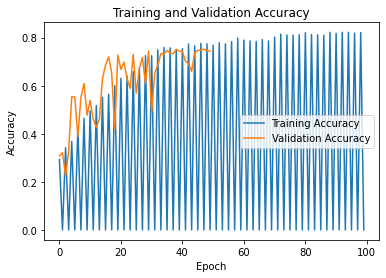

In [7]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [9]:
# Save the model
model.save("proposed_cnn_model.h5")
print("Model saved successfully.")

Model saved successfully.


In [8]:
from tensorflow.keras.models import load_model

model = load_model("proposed_cnn_model.h5")  # Load the saved model


import cv2

image_path = "C:/Users/Siddharth kanoujia/OneDrive/Desktop/aug_0_PMI(70).jpg" # Ensure this path is correct
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Could not load image. Check the file path.")
else:
    print("Image loaded successfully with shape:", image.shape)

import numpy as np

# Resize the image to match the input shape (example: 128x32)
image = cv2.resize(image, (128, 32))  # Update if your model has a different input size

# Normalize pixel values (0-1 range)
image = image / 255.0

# Reshape to match model input shape (batch_size, height, width, channels)
image = np.expand_dims(image, axis=-1)  # Add channel dimension
image = np.expand_dims(image, axis=0)  # Add batch dimension


# Load and preprocess the image
image_path ="C:/Users/Siddharth kanoujia/OneDrive/Desktop/aug_0_PMI(70).jpg"
image = cv2.imread(image_path)  # Load in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image = cv2.resize(image, (227, 227))  # Resize to model input shape
image = image / 255.0  # Normalize pixel values (0 to 1)
image = np.expand_dims(image, axis=0)  # Add batch dimension


# Predict the class
predictions = model.predict(image)
predicted_class = np.argmax(predictions)  # Get the class with the highest probability

# Print the result
print(f"Predicted ECG Class: {predicted_class}")

Image loaded successfully with shape: (227, 227)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicted ECG Class: 1
